<!-- Not content, but for better presentation styles -->
<style>
.rise-enabled .rendered_html table.dataframe {
    font-size: 12px;
}
.rendered_html code {
    background: #EFEFEF;
    border: 1px solid #CCC;
    padding: 1px 5px;
    border-radius: 1px;
}
.rise-enabled .fa-times-circle:before,
.rise-enabled .fa-question:before,
.rise-enabled aside.controls {
    opacity: 0.1;
}
.rise-enabled a,
.rise-enabled a:active,
.rise-enabled a:hover,
.rise-enabled a:visited,
.rise-enabled :link {
    text-decoration: none;
    color: #A68910;
}
</style>```

# Evolving Controllably Difficult Datasets for Clustering

An interactive notebook quickly exploring the paper <a href="https://dl.acm.org/doi/10.1145/3321707.3321761">Evolving Controllably Difficult Datasets for Clustering</a>.
Written by Cameron Shand, Richard  Allmendinger, Julia  Handl, Andrew  Webb, John A Keane. <a href="https://dl.acm.org/doi/10.1145/3321707.3321761">(more info about the authors here)</a>

- Part 1: Presentation of the paper


- Part 2: Simple examples using the associated Python package HAWKS

<a href="https://github.com/sea-shunned/hawks">HAWKS</a> is available on <a href="https://github.com/sea-shunned/hawks">GitHub</a>, and can be installed using <a href="https://pypi.org/project/hawks/">pip</a>
```
pip install hawks
```


## Introduction
Synthetic datasets play an important role in evaluating clustering algorithms, as they can help shed light on consistent biases, strengths,and weaknesses of particular techniques.

HAWKS is a Data generator that uses an evolutionary algorithm to evolve cluster structure of a synthetic data set.

**Main idea**: to produce datasets of a pre-specified difficulty, to trade off different aspects of problem difficulty

Influence the clustering perfomance of established algorithm.

Related work : 

<center><img src='img/Fig1.png'></center>

## Evolving cluster

### Representation
Each individual in the population represents a single dataset of dimensionality D, and (at present) each cluster is described by a multivariate Gaussian.

Each Gaussian is defined by two (sets of) decision variables: 
- a D ×1 vector describing its mean: μ
- the associated D × D covariance matrix: Σ. 

K is the number of clusters and the length of the genotype is thus 2K

<center><img src='img/Fig2.png'></center>

### Objective 
<font size="4">

Maximize the silhouette width i.e. the cluster validity index. 
![Form 1](img/Formula1.png)
    
- a(i) represents the average intra-cluster distance for data point i and is the average distance from i to all other points in the cluster. 
- b(i) represents the inter-cluster distance; for data point i this is defined as the minimum of the average distances to all points in every other cluster.

![Form 2](img/Formula2.png) 

This provides a value in the range [−1, 1], where the **maximum represents very compact and well-separated clusters**. A negative silhouette width value indicates that points in different clusters are not well-separated (and their membership should be changed).
</font>


To better obtain solutions of a desired silhouette width, we specify a target silhouette width (s_t), and the objective (fitness) is to minimize the absolute difference between $s_t$ and $s_{all}$:

$$\min f(\mu_1,\Sigma_1,...,\mu_K,\Sigma_K)=\left | s_t −s_{all} \right |$$

## Evolutionary algorithm 

- Crossover 
- Mutation 
- Eccentricity constraint
- Overlap constraint



### Crossover

<center><img src='img/Fig3.png'></center>

To enhance diversity an uniform crossover is used. Treating $\mu$ and $\Sigma$ as a single unit can results in a lake of diversity.

### Mutation

The mean and covariance parts of the genotype are handled separately with a mutation rate set to $\frac{1}{K}$:

#### Mean mutation

 $\mu_{k}^{new} \sim \it{N}(\mu_{k}^{curr},s)$, New mean vectors are sampled from a Gaussian around current vectors.

#### Covariance mutation

For a given covariance matrix $\Sigma$ we can write $D,P$ such as $\Sigma = PDP^{T}$ and $D$ is the diagonal matrix of the eigenvalues of $\Sigma$ and $P$ the matrix of associated eigenvectors. The mutation of $\Sigma$ aims to modify $D,P$ by applying a transformation matrix. This transformation matrix is comprised of a scaling and rotation matrix. The scaling matrix aims to randomly modify eigenvalues and the rotation matrix aims to modify eigenvectors.

- The scaling matrix modifies $\Sigma$ by maintening $det(\Sigma)$ in order to preserve the volume of the ellipsoid
- The rotation matrix is created as the initial orientation matrix but raised to a given power to ensure that there are similarities from one generation to the next one.

### Constraints
Two constraints are added to improve the algorithm. These constraints provide additionnal control over the complexity of cluster structures and the direct modulation of potential trade-offs.

#### Eccentricity constraint
The eigenvalues of $\Sigma$ directly specify the eccentricity of a given cluster. To control this eccentricity the $\lambda$ ratio between the smallest and largest eigenvalue is calculated.

$$\lambda^{ratio} = \max\limits_{\forall k \in \{ 1,2...,K\}} \frac{max_{\forall i \in \{ 1,2...,K\}} \Sigma_{i,i}^{k}}{min_{\forall i \in \{ 1,2...,K\}} \Sigma_{i,i}^{k}}$$

#### Overlap constraint
As real-world problem can have clusters that overlap because of noise, a minimum amount of overlap is enforced. To do so the overlap is defined as,


$$ overlap = 1 - \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}_{C^i}(i_{nn})$$


where $i_{nn}$ is $i$'s nearest neighbour and $C^i$ is the cluster that data point $i$ belongs to.

<center><img src='img/Fig4.png'></center>

### Evolution of the clusters on 50 generation

<center><img src="https://raw.githubusercontent.com/sea-shunned/hawks/master/docs/source/images/hawks_animation.gif"></center>

# Part 2: Examples using HAWKS

A Python package <a href="https://github.com/sea-shunned/hawks">hawks</a> is available, it can be installed using pip
```
pip install hawks
```

In [33]:
# !pip install hawks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import math
from IPython.display import display
from sklearn import datasets as sk_datasets
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering

In [2]:
import hawks # package from the author of the paper
from hawks.genotype import Genotype

In [3]:
n_samples = 1000
# Set the magic seed number
SEED_NUM = 42
# Set the seed number in the config
config = {
    "hawks": {
        "seed_num": SEED_NUM,
        "num_runs": 1,
    },
     "objectives": {
        "silhouette": {
            "target": 0.9 # default is 8
        }
    },
    "dataset": {
        "num_clusters": 4, # default is 10
        "num_examples": n_samples, # default is 1000
    },
    "ga": {
        "num_gens": 50,
        "prob_fitness": 0.5,
    },
    "constraints": {
        "overlap": {
            "threshold": 0.0,
            "limit": "upper"
        },
        "eigenval_ratio": {
            "threshold": 1000,
            "limit": "upper"
        }
    }
}
# Any missing parameters will take from hawks/defaults.json


In [192]:
generator = hawks.create_generator(config)
# Run the generator
generator.run()
# Get the best dataset found and it's labels
datasets, label_sets = generator.get_best_dataset()
hawks_set = (datasets[0], label_sets[0]) # Stored as a list for multiple runs

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:09,  5.11it/s]

Generations:   4%|▍         | 2/49 [00:00<00:08,  5.41it/s]

Generations:   6%|▌         | 3/49 [00:00<00:08,  5.62it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  5.82it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.84it/s]

Generations:  12%|█▏        | 6/49 [00:00<00:07,  6.04it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:06,  6.24it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:06,  6.16it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  6.23it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  6.30it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:05,  6.38it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:05,  6.24it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.48it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:05,  6.27it/s]

Generations:  31%|███       | 15/49 [00:02<

In [186]:
# Generate some datasets with different methods
circles = sk_datasets.make_circles(n_samples=n_samples, factor=0.5, noise=.05)
blobs = sk_datasets.make_blobs(n_samples=n_samples, random_state=8, centers=4)

labels = ['scikit-learn ‘circles’', 'scikit-learn ‘blobs’', "HAWKS"]
sets = [circles, blobs, hawks_set]

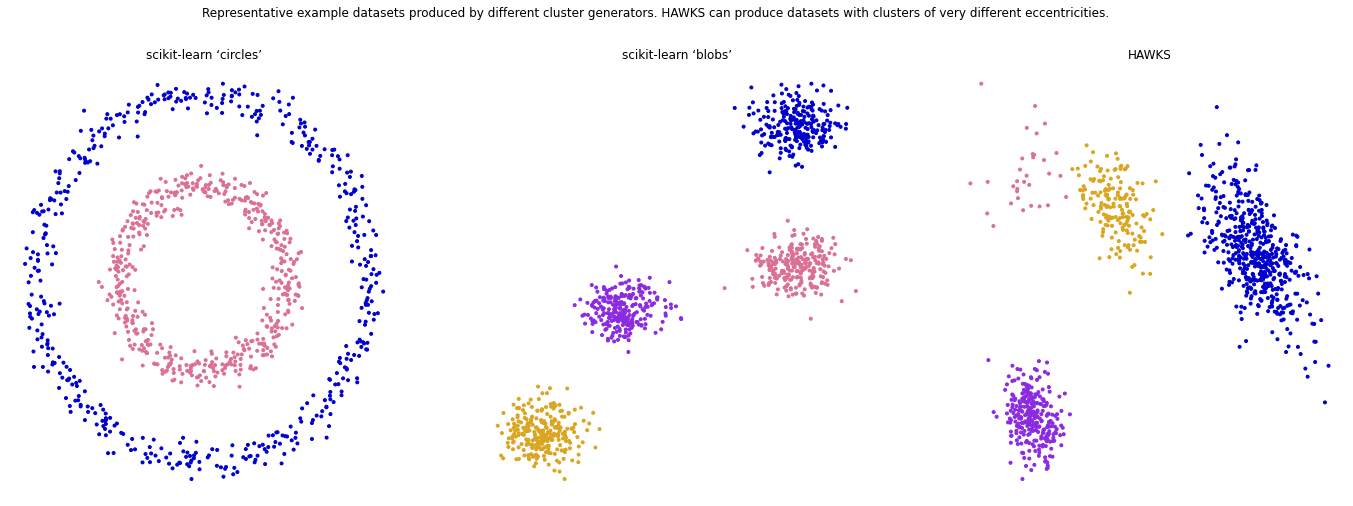

In [196]:
ncol = 3
fig, axs = plt.subplots(1, ncol, figsize=(24,8))
fig.suptitle("Representative example datasets produced by different cluster generators. HAWKS can produce datasets with clusters of very different eccentricities.")
colors = np.array(['mediumblue', 'palevioletred', 'goldenrod', 'blueviolet'])

for i, (data, label) in enumerate(zip(sets, labels)):
    X, y = data
    ax = axs[i%ncol]
    ax.scatter(X[:, 0], X[:, 1], color=colors[y], marker='.')
    ax.set_title(label)
    ax.axis('off')

## Congif variation

In [5]:
def plot_pop_configs(generator, params_tested, title):
    best_indivs = [ b[0] for b in generator.best_each_run]
    nb_config = len(best_indivs)
    df_best = generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")
    fig, axs = plt.subplots(1,nb_config, figsize=(20, 6))
    fig.suptitle(title,  y=1.05)
    for i, indiv in enumerate(best_indivs):
        ax = axs[i]
        hawks.plotting.plot_indiv(indiv, ax=ax, multiple=True)
        axtitle = "\n".join([f"{param_tested}={df_best.loc[i][param_tested]}" for param_tested in params_tested])
        ax.set_title(axtitle, wrap=True)
    fig.tight_layout()

In [55]:
# Try three different silhouette width target values
SEED_NUM = 21
config = {
    "hawks": {
        "seed_num": SEED_NUM
    },
    "objectives": {
        "silhouette": {
            "target": [0.2, 0.5, 0.8]
        }
    },
    "dataset": {
        "num_clusters": [4]
    }
}
# Any missing parameters will take from hawks/defaults.json
generator = hawks.create_generator(config)
# Run the generator
generator.run()

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:08,  5.44it/s]

Generations:   4%|▍         | 2/49 [00:00<00:08,  5.53it/s]

Generations:   6%|▌         | 3/49 [00:00<00:08,  5.63it/s]

Generations:   8%|▊         | 4/49 [00:00<00:08,  5.60it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.58it/s]

Generations:  12%|█▏        | 6/49 [00:01<00:07,  5.62it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.84it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:07,  5.82it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  5.82it/s]

Generations:  20%|██        | 10/49 [00:01<00:07,  5.53it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  5.93it/s]

Generations:  24%|██▍       | 12/49 [00:02<00:06,  5.72it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:06,  5.64it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:06,  5.53it/s]

Generations:  31%|███       | 15/49 [00:02<

Generations:  27%|██▋       | 13/49 [00:02<00:06,  5.70it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:06,  5.75it/s]

Generations:  31%|███       | 15/49 [00:02<00:05,  6.00it/s]

Generations:  33%|███▎      | 16/49 [00:02<00:05,  5.82it/s]

Generations:  35%|███▍      | 17/49 [00:02<00:05,  5.97it/s]

Generations:  37%|███▋      | 18/49 [00:02<00:05,  6.16it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:05,  5.88it/s]

Generations:  41%|████      | 20/49 [00:03<00:04,  5.93it/s]

Generations:  43%|████▎     | 21/49 [00:03<00:04,  5.91it/s]

Generations:  45%|████▍     | 22/49 [00:03<00:04,  5.82it/s]

Generations:  47%|████▋     | 23/49 [00:03<00:04,  5.85it/s]

Generations:  49%|████▉     | 24/49 [00:04<00:04,  5.84it/s]

Generations:  51%|█████     | 25/49 [00:04<00:04,  5.83it/s]

Generations:  53%|█████▎    | 26/49 [00:04<00:03,  5.75it/s]

Generations:  55%|█████▌    | 27/49 [00:04<00:03,  5.75it/s]

Generations:  57%|█████▋    | 28/49 [00:04<00:03,  5.97it/s]

Generati

In [56]:
generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")

,silhouette_target,num_clusters,run,indiv,gen,silhouette,fitness_silhouette,eigenval_ratio,overlap,best_indiv
config_id,,,,,,,,,,
0,0.2,4,0,7,49,0.204597,0.004597,17.746130,0.067,1
1,0.5,4,0,9,49,0.482327,0.017673,7.740902,0.112,1
2,0.8,4,0,1,49,0.799755,0.000245,16.840999,0.000,1


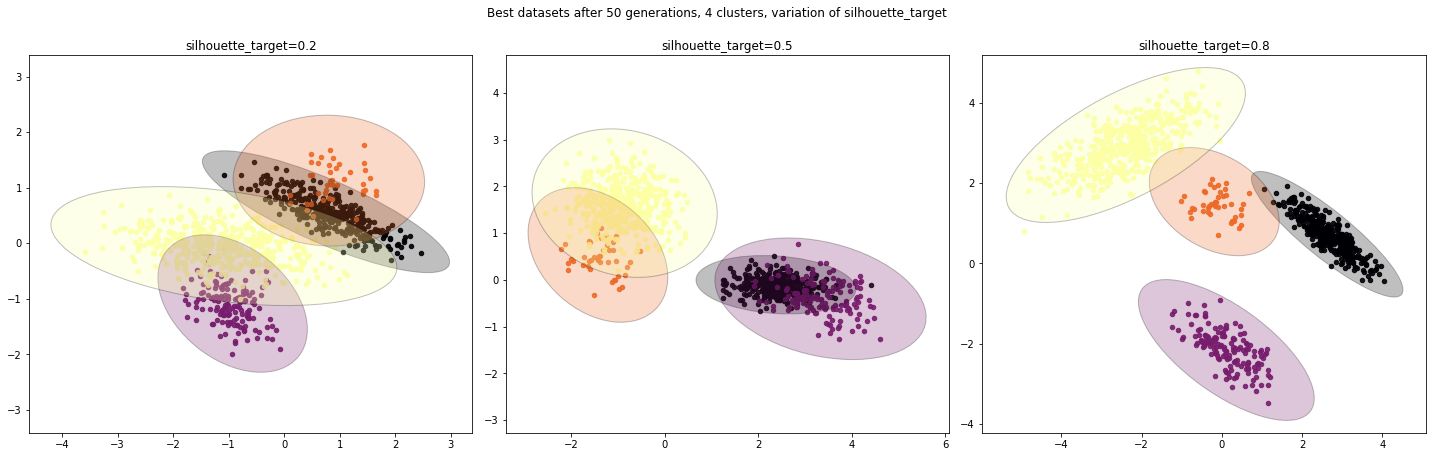

In [57]:
plot_pop_configs(generator, ["silhouette_target"], "Best datasets after 50 generations, 4 clusters, variation of silhouette_target")

In [224]:
# Try three different overlap_threshold target values
config = {
    "hawks": {
        "seed_num": SEED_NUM
    },
    "objectives": {
        "silhouette": {
            "target": 0.8
        }
    },
    "dataset": {
        "num_clusters": [4]
    },
    "constraints": {
        "overlap": {
            "threshold": [0.0, 0.2, 0.5],
            "limit": "upper"
        },
        "eigenval_ratio": {
            "threshold": 20,
            "limit": "upper"
        }
    }
}
# Any missing parameters will take from hawks/defaults.json
generator = hawks.create_generator(config)
# Run the generator
generator.run()

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:08,  5.47it/s]

Generations:   4%|▍         | 2/49 [00:00<00:08,  5.73it/s]

Generations:   6%|▌         | 3/49 [00:00<00:07,  5.86it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  5.99it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.85it/s]

Generations:  12%|█▏        | 6/49 [00:00<00:07,  5.97it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.96it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:06,  6.00it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  6.02it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  5.96it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  6.17it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:05,  6.18it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.26it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:05,  6.25it/s]

Generations:  31%|███       | 15/49 [00:02<

In [225]:
generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")

,num_clusters,overlap_threshold,run,indiv,gen,silhouette,fitness_silhouette,eigenval_ratio,overlap,best_indiv
config_id,,,,,,,,,,
0,4,0.0,0,0,49,0.799324,0.000676,10.245577,0.000999,1
1,4,0.2,0,0,49,0.799989,0.000011,18.774011,0.039960,1
2,4,0.5,0,3,49,0.800066,0.000066,9.422446,0.007992,1


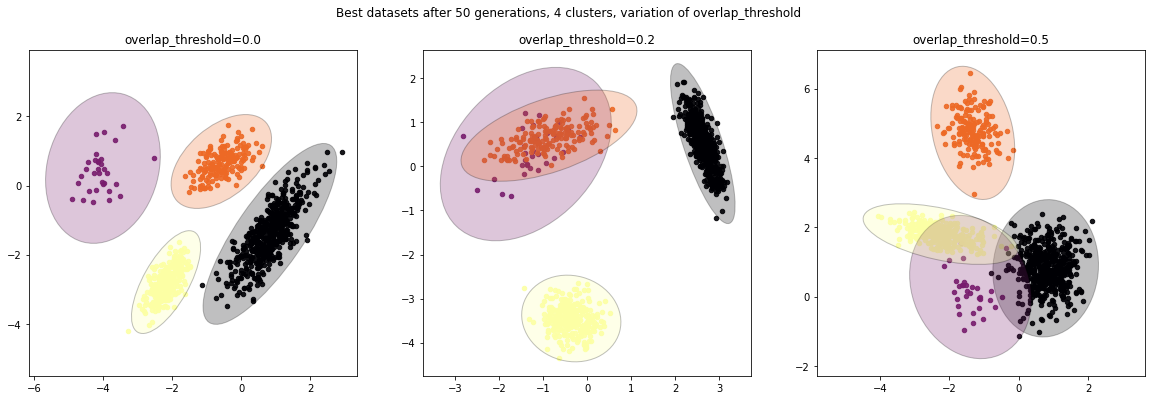

In [227]:
plot_pop_configs(generator, ["overlap_threshold"], "Best datasets after 50 generations, 4 clusters, silhouette_target=0.8, variation of overlap_threshold")

### Relation between the average silhouette width $s_{all}$ and $overlap$

<center><img src='img/Fig5.png'></center>

In [233]:
# Try two different overlap_threshold and two eigenval_ratio_limit target values
config = {
    "hawks": {
        "seed_num": SEED_NUM
    },
    "objectives": {
        "silhouette": {
            "target": 0.8
        }
    },
    "dataset": {
        "num_clusters": [4]
    },
    "constraints": {
        "overlap": {
            "threshold": [0.0, 0.5],
            "limit": "upper"
        },
        "eigenval_ratio": {
            "threshold": 20,
            "limit": ["upper", "lower"]
        }
    }
}
# Any missing parameters will take from hawks/defaults.json
generator = hawks.create_generator(config)
# Run the generator
generator.run()

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:10,  4.80it/s]

Generations:   4%|▍         | 2/49 [00:00<00:09,  5.17it/s]

Generations:   6%|▌         | 3/49 [00:00<00:08,  5.48it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  5.71it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.76it/s]

Generations:  12%|█▏        | 6/49 [00:01<00:07,  5.97it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.99it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:06,  6.01it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  6.02it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  5.96it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  6.13it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:05,  6.21it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.38it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:05,  6.39it/s]

Generations:  31%|███       | 15/49 [00:02<

In [234]:
generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")

,num_clusters,overlap_threshold,eigenval_ratio_limit,run,indiv,gen,silhouette,fitness_silhouette,eigenval_ratio,overlap,best_indiv
config_id,,,,,,,,,,,
0,4,0.0,upper,0,0,49,0.799324,0.000676,10.245577,0.000999,1
1,4,0.0,lower,0,0,49,0.802603,0.002603,118.238460,0.006993,1
2,4,0.5,upper,0,3,49,0.800066,0.000066,9.422446,0.007992,1
3,4,0.5,lower,0,0,49,0.800012,0.000012,104.501522,0.006993,1


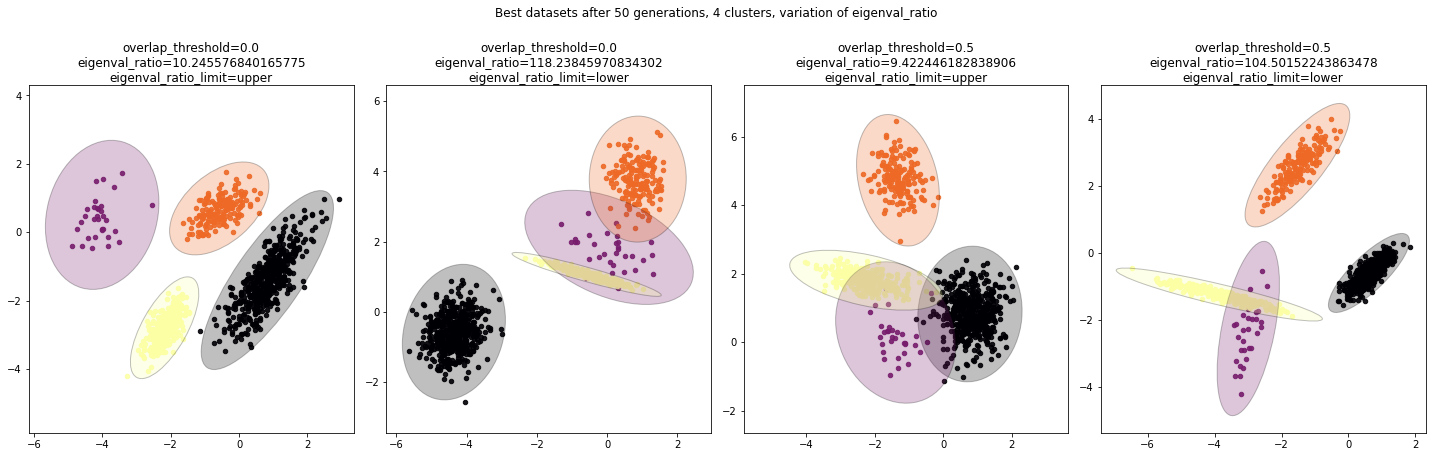

In [243]:
plot_pop_configs(generator, ["overlap_threshold", "eigenval_ratio", "eigenval_ratio_limit"], 
                 "Best datasets after 50 generations, 4 clusters, variation of eigenval_ratio")

# Visualisation of the increased difficulty

In [104]:
# Define some function
def run_config(config):
    generator = hawks.create_generator(config)
    generator.run()
    return generator

def analyse_mean(generator):
    df, _ = hawks.analysis.analyse_datasets(
        generator=generator,
        seed=SEED_NUM,
        save=False
    )
    df = df.set_index("config_num")
    df_best = generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")
    df_best.index.names = ["config_num"]
    df = pd.concat([df,df_best])
    return df.groupby("config_num").mean()

cluster_algo_labels = ["c_Average-Linkage", "c_Average-Linkage (2K)", "c_GMM", "c_K-Means++", "c_Single-Linkage", "c_Single-Linkage (2K)"]

def plot_param_variation(df, param_target, param_real, marker='.', figsize=(15,10), logx=False):
    ax = df.set_index(param_real)[cluster_algo_labels].plot(
        figsize=figsize, 
        logx= logx,
        marker=marker,
        ylabel='ARI Score',
        title=f"Score of clustering algorithms with different {param_target}: {df[param_target].values}"
    )
    # Annotation
    dfa = df.set_index(param_target)[[param_real]]
    dfa["c_max"] = df.set_index(param_target)[cluster_algo_labels].max(axis=1)
    ymin = df[cluster_algo_labels].min(axis=1).min()
    for target, v in dfa.iterrows(): #TODO use max of cluster_algo_labels to annotate the higher point
        ax.annotate(target, v, textcoords='offset pixels', xytext=(-5,10))
        ax.annotate(f"{v[0]:.2f}", (v[0], ymin), xytext=(v[0], ymin - 0.1*ymin))

## Variation of silhouette target

In [74]:
# Variation of silhouettes
SEED_NUM = 21
silhouettes = list(np.linspace(0.2,0.9,num=8))
config_silhouettes = {
    "hawks": {
        "seed_num": SEED_NUM,
        "num_runs": 4,
    },
    "objectives": {
        "silhouette": {
            "target": silhouettes
        }
    },
    "dataset": {
        "num_clusters": 4
    },
}
gen_s = run_config(config_silhouettes)

In [8]:
dfs = analyse_mean(gen_s)
dfs.head(2)

,dataset_num,num_examples,num_clusters,c_Average-Linkage,c_Average-Linkage (2K),c_GMM,c_K-Means++,c_Single-Linkage,c_Single-Linkage (2K),f_dimensionality,...,f_silhouette,silhouette_target,run,indiv,gen,silhouette,fitness_silhouette,eigenval_ratio,overlap,best_indiv
config_num,,,,,,,,,,,,,,,,,,,,,
0,1.5,1000.25,4.0,0.552706,0.49093,0.626425,0.350911,0.211327,0.215575,2.0,...,0.208548,0.2,1.5,2.75,49.0,0.208548,0.008548,14.188770,0.079475,1.0
1,5.5,1000.25,4.0,0.753797,0.65540,0.674751,0.546608,0.498319,0.635111,2.0,...,0.327475,0.3,1.5,2.75,49.0,0.327475,0.027475,14.454807,0.036732,1.0


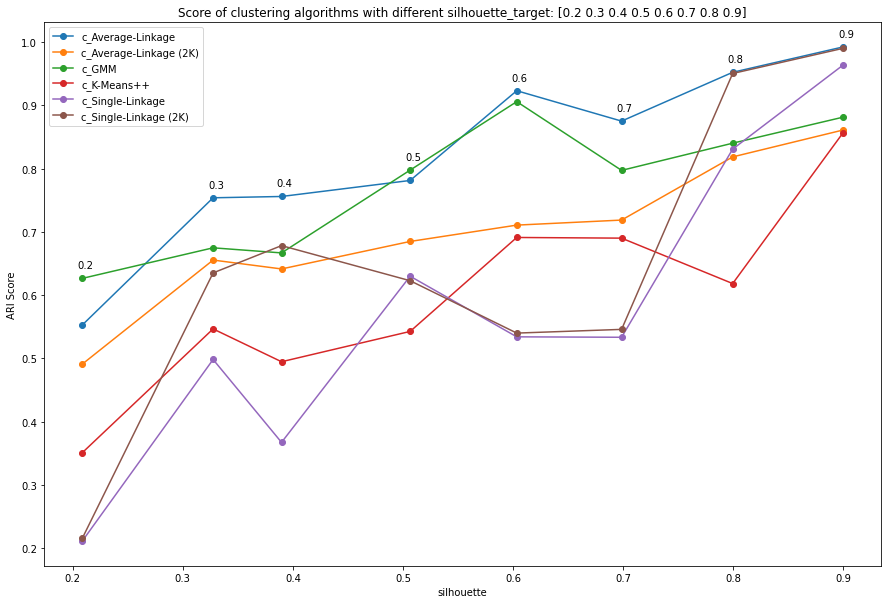

In [64]:
plot_param_variation(dfs, "silhouette_target", "silhouette", marker='o')

## Variation of overlap

In [71]:
# Variation of overlap
SEED_NUM = 21
overlaps = list(np.linspace(0.0,1,num=11))
config_overlaps = {
    "hawks": {
        "seed_num": SEED_NUM,
        "num_runs": 4,
    },
    "objectives": {
        "silhouette": {
            "target": 0.2
        }
    },
    "dataset": {
        "num_clusters": 4
    },
    "ga": {
        "prob_fitness": 0.2,
    },
    "constraints": {
        "overlap": {
            "threshold": overlaps,
            "limit": "upper"
        }
    }
}
gen_o = run_config(config_overlaps)

.28it/s]

Generations:  37%|███▋      | 18/49 [00:03<00:05,  5.40it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:05,  5.33it/s]

Generations:  41%|████      | 20/49 [00:04<00:05,  5.47it/s]

Generations:  43%|████▎     | 21/49 [00:04<00:05,  5.21it/s]

Generations:  45%|████▍     | 22/49 [00:04<00:05,  5.19it/s]

Generations:  47%|████▋     | 23/49 [00:04<00:04,  5.28it/s]

Generations:  49%|████▉     | 24/49 [00:04<00:04,  5.40it/s]

Generations:  51%|█████     | 25/49 [00:05<00:04,  5.02it/s]

Generations:  53%|█████▎    | 26/49 [00:05<00:04,  5.14it/s]

Generations:  55%|█████▌    | 27/49 [00:05<00:04,  5.00it/s]

Generations:  57%|█████▋    | 28/49 [00:05<00:04,  5.11it/s]

Generations:  59%|█████▉    | 29/49 [00:05<00:04,  4.97it/s]

Generations:  61%|██████    | 30/49 [00:06<00:03,  4.94it/s]

Generations:  63%|██████▎   | 31/49 [00:06<00:03,  4.81it/s]

Generations:  65%|██████▌   | 32/49 [00:06<00:03,  4.87it/s]

Generations:  67%|██████▋   | 33/49 [00:06<00:03,  5.06it/s]

In [72]:
dfo = analyse_mean(gen_o)
dfo.head(2)

,dataset_num,num_examples,num_clusters,c_Average-Linkage,c_Average-Linkage (2K),c_GMM,c_K-Means++,c_Single-Linkage,c_Single-Linkage (2K),f_dimensionality,...,f_silhouette,overlap_threshold,run,indiv,gen,silhouette,fitness_silhouette,eigenval_ratio,overlap,best_indiv
config_num,,,,,,,,,,,,,,,,,,,,,
0,1.5,1000.25,4.0,0.802416,0.740230,0.856727,0.829974,0.610857,0.702751,2.0,...,0.800042,0.0,1.5,1.50,49.0,0.800042,0.000246,15.234975,0.000000,1.0
1,5.5,1000.25,4.0,0.888899,0.831834,0.782294,0.740918,0.582970,0.589443,2.0,...,0.800033,0.1,1.5,0.75,49.0,0.800033,0.000034,8.426248,0.022495,1.0


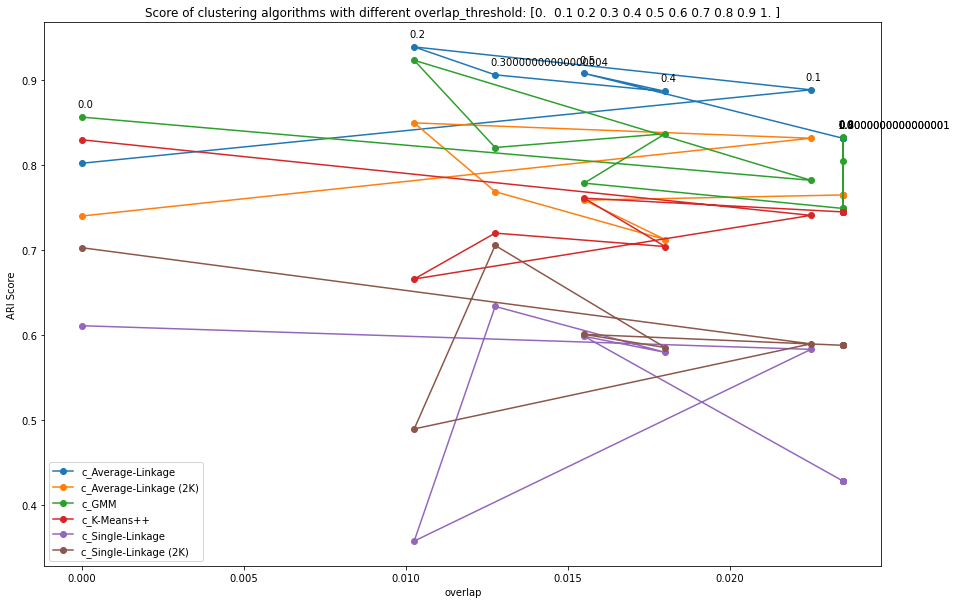

In [73]:
plot_param_variation(dfo, "overlap_threshold", "overlap", marker='o')

## Variation of eccentricity via eigenval_ratio 

In [75]:
# Variation of eccentricity
SEED_NUM = 21
eigenval_ratios = [0, 10, 20, 50, 100, 500, 1000, 5000]
config_eigenval = {
    "hawks": {
        "seed_num": SEED_NUM,
        "num_runs": 4,
    },
    "dataset": {
        "num_clusters": 4
    },
    "objectives": {
        "silhouette": {
            "target": 0.2
        }
    },
    "ga": {
        "prob_fitness": 0.2,
    },
    "constraints": {
        "eigenval_ratio": {
            "threshold": eigenval_ratios,
            "limit": "lower"
        }
    }
}
gen_e = run_config(config_eigenval)

,  5.77it/s]

Generations:  37%|███▋      | 18/49 [00:03<00:05,  5.53it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:05,  5.34it/s]

Generations:  41%|████      | 20/49 [00:03<00:05,  5.23it/s]

Generations:  43%|████▎     | 21/49 [00:03<00:05,  5.12it/s]

Generations:  45%|████▍     | 22/49 [00:04<00:05,  5.05it/s]

Generations:  47%|████▋     | 23/49 [00:04<00:04,  5.25it/s]

Generations:  49%|████▉     | 24/49 [00:04<00:04,  5.43it/s]

Generations:  51%|█████     | 25/49 [00:04<00:04,  5.43it/s]

Generations:  53%|█████▎    | 26/49 [00:04<00:04,  5.58it/s]

Generations:  55%|█████▌    | 27/49 [00:04<00:03,  5.68it/s]

Generations:  57%|█████▋    | 28/49 [00:05<00:03,  5.73it/s]

Generations:  59%|█████▉    | 29/49 [00:05<00:03,  5.53it/s]

Generations:  61%|██████    | 30/49 [00:05<00:03,  5.56it/s]

Generations:  63%|██████▎   | 31/49 [00:05<00:03,  5.55it/s]

Generations:  65%|██████▌   | 32/49 [00:05<00:03,  5.29it/s]

Generations:  67%|██████▋   | 33/49 [00:06<00:03,  5.16i

In [85]:
dfe = analyse_mean(gen_e)
dfe.head(10)

,dataset_num,num_examples,num_clusters,c_Average-Linkage,c_Average-Linkage (2K),c_GMM,c_K-Means++,c_Single-Linkage,c_Single-Linkage (2K),f_dimensionality,...,f_silhouette,eigenval_ratio_threshold,run,indiv,gen,silhouette,fitness_silhouette,eigenval_ratio,overlap,best_indiv
config_num,,,,,,,,,,,,,,,,,,,,,
0,1.5,1000.25,4.0,0.891471,0.807657,0.872531,0.626149,0.543358,0.731820,2.0,...,0.671183,0.0,1.5,2.75,49.0,0.671183,0.471183,300.280157,0.0005,1.0
1,5.5,1000.25,4.0,0.841593,0.892942,0.998780,0.843443,0.545033,0.871214,2.0,...,0.767912,10.0,1.5,0.00,49.0,0.767912,0.567912,54.491775,0.0000,1.0
2,9.5,1000.25,4.0,0.660086,0.784056,1.000000,0.651992,0.633580,0.718122,2.0,...,0.646220,20.0,1.5,0.75,49.0,0.646220,0.446220,170.805431,0.0000,1.0
3,13.5,1000.25,4.0,0.889007,0.602504,1.000000,0.602929,0.473795,0.648609,2.0,...,0.601144,50.0,1.5,0.00,49.0,0.601144,0.401144,81.102780,0.0000,1.0
4,17.5,1000.25,4.0,0.831451,0.843805,0.978105,0.884162,0.771806,0.843256,2.0,...,0.687175,100.0,1.5,0.00,49.0,0.687175,0.487175,402.822853,0.0000,1.0
5,21.5,1000.25,4.0,0.663656,0.939377,0.998626,0.735455,0.229903,0.330507,2.0,...,0.704634,500.0,1.5,0.00,49.0,0.704634,0.504634,1786.142914,0.0000,1.0
6,25.5,1000.25,4.0,0.712388,0.918363,0.980126,0.853079,0.625346,0.717156,2.0,...,0.635352,1000.0,1.5,0.00,49.0,0.635352,0.435352,4136.154416,0.0000,1.0
7,29.5,1000.25,4.0,0.611363,0.949899,0.969111,0.889949,0.601939,0.825843,2.0,...,0.713149,5000.0,1.5,0.00,49.0,0.713149,0.513149,12872.250086,0.0000,1.0


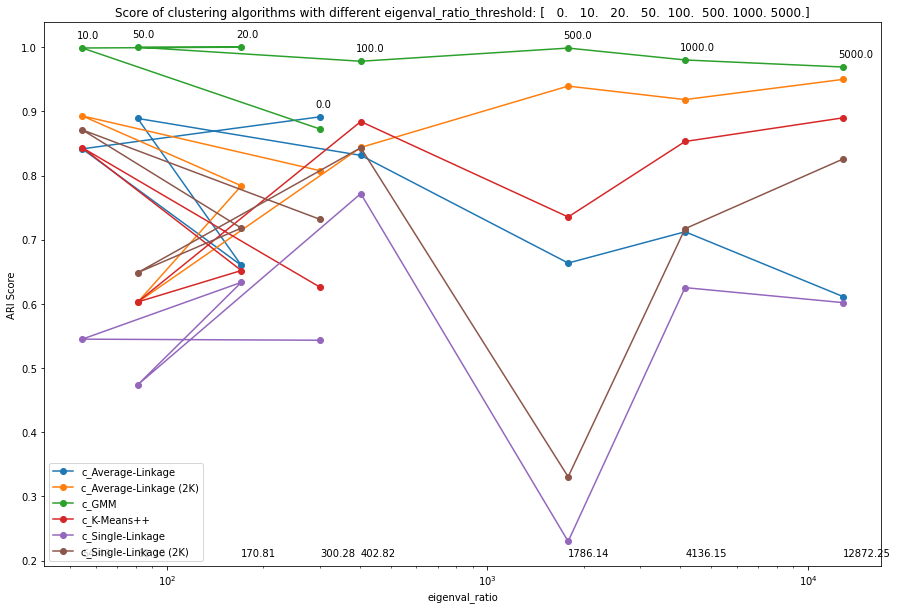

In [105]:
plot_param_variation(dfe, "eigenval_ratio_threshold", "eigenval_ratio", marker='o', logx=True)

In [84]:
# generator.plot_best_indivs(show=True)

### The stochastic ranking parameter $P_f$ 


<center><img src='img/Fig6.png'></center>

## Result from the paper

<center><img src='img/Table1.png'></center>

<center><img src='img/Fig7and8.png'></center>